In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats.mstats as ssm

In [2]:
# load the data
filename = 'CrowdstormingDataJuly1st.csv'
df = pd.read_csv(filename)

## Understanding the data

In [ ]:
df['ties'].unique()

In [ ]:
df['refNum'].unique()

In [ ]:
df[df.playerShort == 'aaron-hughes'].ix[:,13:]

#### Number of NaN in rater2

In [3]:
df.groupby(['playerShort','refNum']).mean().ix[:10,:]

height  weight  games  victories  ties  defeats  goals  \
playerShort  refNum                                                           
aaron-hughes 4        182.0    71.0      1          0     0        1      0   
             66       182.0    71.0      1          1     0        0      0   
             77       182.0    71.0     26         13     8        5      0   
             163      182.0    71.0      2          1     1        0      0   
             194      182.0    71.0     16          3     5        8      0   
             233      182.0    71.0     10          3     4        3      0   
             237      182.0    71.0      1          1     0        0      0   
             238      182.0    71.0      1          1     0        0      0   
             256      182.0    71.0     10          4     4        2      0   
             260      182.0    71.0      1          0     0        1      0   

                     yellowCards  yellowReds  redCards  rater1  rater2  \
playerShort  refNum                                                      
aaron-hughes 4                 0           0         0    0.25     0.0   
             66                0           0         0    0.25     0.0   
             77                0           0         0    0.25     0.0   
             163               0           0         0    0.25     0.0   
             194               2           0         0    0.25     0.0   
             233               2           0         0    0.25     0.0   
             237               0           0         0    0.25     0.0   
             238               0           0         0    0.25     0.0   
             256               0           0         0    0.25     0.0   
             260               0           0         0    0.25     0.0   

                     refCountry   meanIAT     nIAT     seIAT   meanExp  \
playerShort  refNum                                                      
aaron-hughes 4                4  0.325185    127.0  0.003297  0.538462   
             66               4  0.325185    127.0  0.003297  0.538462   
             77              44  0.326690  44791.0  0.000010  0.356446   
             163             65  0.379424    925.0  0.000464  0.559375   
             194             44  0.326690  44791.0  0.000010  0.356446   
             233             44  0.326690  44791.0  0.000010  0.356446   
             237             44  0.326690  44791.0  0.000010  0.356446   
             238             44  0.326690  44791.0  0.000010  0.356446   
             256             44  0.326690  44791.0  0.000010  0.356446   
             260             76  0.429987    139.0  0.002622  0.668966   

                        nExp     seExp  
playerShort  refNum                     
aaron-hughes 4         130.0  0.013752  
             66        130.0  0.013752  
             77      46916.0  0.000037  
             163       960.0  0.001927  
             194     46916.0  0.000037  
             233     46916.0  0.000037  
             237     46916.0  0.000037  
             238     46916.0  0.000037  
             256     46916.0  0.000037  
             260       145.0  0.012878

In [4]:
df['victories'] = df['victories']/df['games']
df['ties'] = df['ties']/df['games']
df['defeats'] = df['defeats']/df['games']

## Assignment 1: 

In [5]:
df['rater_average'] = (df['rater1']+df['rater2'])/2

In [6]:
del df['player']; del df['rater1']; del df['rater2']; del df['photoID']

In [7]:
dic_country = {'Spain':0, 'France':1, 'England':2, 'Germany':3}

In [ ]:
dic_country

In [8]:
df['leagueCountry'] = df.apply(lambda x: dic_country[x.loc['leagueCountry']], axis=1)

In [9]:
# testing data
testing_data_x = df[np.isnan(df['rater_average'])]
# training data
training_data = df.dropna()
training_data_x = training_data.ix[:,:-1]
training_data_y = (training_data.ix[:,-1]*8).astype(int)
#training_data_x = df[~np.isnan(df['rater_average'])].ix[:,:-1]
#training_data_y = df[~np.isnan(df['rater_average'])].ix[:,-1]


In [10]:
training_data_x['Alpha_3'].fillna('unknown',inplace = True)

In [11]:
club_name = training_data_x['club'].unique()
num_of_clubs = len(club_name)
club_index = np.arange(0, num_of_clubs)
club_name_index_map = dict(zip(club_name,club_index))
training_data_x['club'] = training_data_x.apply(lambda x: club_name_index_map[x.loc['club']], axis=1)

In [16]:
training_data_x

,club,leagueCountry,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,177.0,72.0,1,0.0,0.0,1.0,0,0,0,0,1,1,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,1,179.0,82.0,1,0.0,0.0,1.0,0,1,0,0,2,2,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,2,2,182.0,71.0,1,0.0,0.0,1.0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,3,2,187.0,80.0,1,1.0,0.0,0.0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,4,2,180.0,68.0,1,0.0,0.0,1.0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,5,2,193.0,80.0,1,0.0,1.0,0.0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,6,3,180.0,70.0,1,1.0,0.0,0.0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
10,7,0,177.0,74.0,2,1.0,0.0,0.0,0,1,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
11,2,2,181.0,74.0,1,1.0,0.0,0.0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752
12,8,3,187.0,80.0,1,1.0,0.0,0.0,0,0,0,0,4,4,0.325185,127.0,0.003297,0.538462,130.0,0.013752


In [13]:
del training_data_x['playerShort']; del training_data_x['position']; del training_data_x['Alpha_3']; 

In [15]:
del training_data_x['birthday']; 

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [23]:
# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
a = []
for i in range(1,20):
    clf = RandomForestClassifier(n_estimators=i)
    a1 = cross_val_score(clf,training_data_x, training_data_y, cv = 5).mean()
    a.append(a1)
    print(a1)

0.560453643491
0.595628495779
0.652633150358
0.68518567976
0.741039637007
0.756373834906
0.74187408163
0.735167400482
0.790402343282
0.777118834564
0.727837378279
0.783725815688
0.765171306265
0.778583497463
0.809880005046
0.806562675282
0.813700917329
0.79118705738
0.81839536505


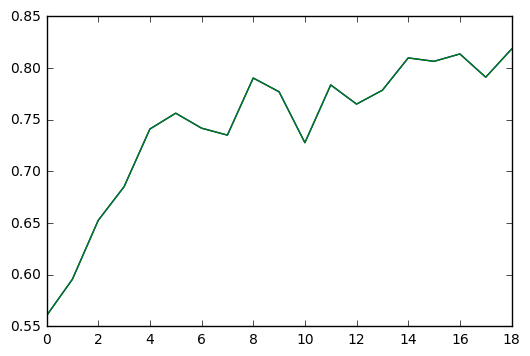

In [25]:
plt.plot(a)
plt.show()